# Titanic Survival Part 2: Machine Learning Predictions in Python

In [83]:
# import modules
import numpy as np 
import pandas as pd 
import os
import re 

# load train dataset 
train = pd.read_csv("../input/train.csv")

In [84]:
# simplify Name
def extract_title(a_name):
    """Given a name from the Name column, extract the title by searching for the pattern, 
       returning a tuple that identifies whether the regex worked or not.
    """
    try:
        return (True, *tuple(re.search(r',\s(.+?)\.', a_name).groups()))
    except:
        return (False, a_name)
    
parsed_name = train['Name'].map(lambda x: extract_title(x))    

In [85]:
# ensure all names were parsed
def sum_line(line):
    ct = 0
    if line[0] == True:
        ct += 1
    return ct

passed = parsed_name.map(lambda x: sum_line(x))
assert sum(passed) == len(parsed_name)

In [86]:
# create Title
def simplify_title(x):
    """"Given a parsed name, extract the title from the tuple, 
       if it belongs to a common title, return that, otherwise, return 'rare'
    """
    try:
        a,b = x
        if b in ["Mr", "Mrs", "Miss"]:
            return (b)
        else:
            return ('Rare')
    except:
        return ('')

train['Title'] = parsed_name.map(lambda x: simplify_title(x))

In [87]:
# Create NameLength
train['NameLength'] = train['Name'].map(lambda x: len(x))

In [88]:
# Create NumRelatives
train['NumRelatives'] = train['SibSp'] + train['Parch']

In [89]:
# Create FarePerPerson
train['count'] = 1
group = train[['Ticket','Fare','count']].groupby('Ticket').sum()
group['Fare'] = group['Fare']/group['count']
group['FarePerPerson'] = (group['Fare'])/group['count']

def map_fare_perperson(ticket):
    """Counts people per tickets and divides the fare per number of people in a ticket.
    Uses the group helper table with aggregated results.
    """

    row_names=np.array(list(group.index.values))
    loc=np.where(row_names == ticket)[0][0]
    
    return(group['FarePerPerson'][loc:loc+1][0])

train['FarePerPerson'] = train['Ticket'].map(lambda x: map_fare_perperson(x))

In [90]:
# Create Deck - just first letter (Deck)

#leaving NA values (will just be 0s in one-hot encoding)
def clean_cabin(x):
    """Extract the Deck information, first letter only, 
    Limit to six groups, A through F, binning other decks to F.
    """
    
    letter=x[0]
    
    if letter not in 'ABCDEF':
        letter='F'
        
    return(letter)
    
train['Deck']=train['Cabin'].map(lambda x: clean_cabin(x), na_action='ignore')

In [91]:
# Embarked
# impute two missing with majority class
train['Embarked']=train['Embarked'].fillna('S')

In [92]:
# Age
# impute with group medians given gender, passenger class, and title
train['Age'] = train.groupby(['Sex', 'Pclass','Title'])['Age'].transform(lambda x: x.fillna(x.median()))

## Binary Indicators:

In [93]:
# Sex
train['IsMale'] = pd.get_dummies(train['Sex'])['male']

In [94]:
# Embarked
train['Embarked_S']=pd.get_dummies(train['Embarked'])['S']
train['Embarked_Q']=pd.get_dummies(train['Embarked'])['Q']

In [95]:
# Title
train['Title_Mr']=pd.get_dummies(train['Title'])['Mr']
train['Title_Mrs']=pd.get_dummies(train['Title'])['Mrs']
train['Title_Miss']=pd.get_dummies(train['Title'])['Miss']

In [96]:
# Pclass
train['Pclass_1']=pd.get_dummies(train['Pclass'])[1]
train['Pclass_2']=pd.get_dummies(train['Pclass'])[2]

In [97]:
# Deck
train['Deck'].fillna('None') # create a None category for NA values
train['Deck_A']=pd.get_dummies(train['Deck'])['A']
train['Deck_B']=pd.get_dummies(train['Deck'])['B']
train['Deck_C']=pd.get_dummies(train['Deck'])['C']
train['Deck_D']=pd.get_dummies(train['Deck'])['D']
train['Deck_E']=pd.get_dummies(train['Deck'])['E']
train['Deck_F']=pd.get_dummies(train['Deck'])['F']

In [98]:
# drop unwanted, redundant columns
train.drop(['PassengerId', 'Pclass','Name','Sex','SibSp','Parch','Ticket','Fare',\
            'Cabin','count','Embarked','Title','Deck'], axis=1, inplace=True)

In [99]:
train.head()

,Survived,Age,NameLength,NumRelatives,FarePerPerson,IsMale,Embarked_S,Embarked_Q,Title_Mr,Title_Mrs,Title_Miss,Pclass_1,Pclass_2,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F
0,0,22.0,23,1,7.2500,1,1,0,1,0,0,0,0,0,0,0,0,0,0
1,1,38.0,51,1,71.2833,0,0,0,0,1,0,1,0,0,0,1,0,0,0
2,1,26.0,22,0,7.9250,0,1,0,0,0,1,0,0,0,0,0,0,0,0
3,1,35.0,44,1,26.5500,0,1,0,0,1,0,1,0,0,0,1,0,0,0
4,0,35.0,24,0,8.0500,1,1,0,1,0,0,0,0,0,0,0,0,0,0


In [100]:
# separate dependent and independent variables
survived_labels = train['Survived'].copy()
train = train.drop('Survived', axis=1) 

In [101]:
train.head()

,Age,NameLength,NumRelatives,FarePerPerson,IsMale,Embarked_S,Embarked_Q,Title_Mr,Title_Mrs,Title_Miss,Pclass_1,Pclass_2,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F
0,22.0,23,1,7.2500,1,1,0,1,0,0,0,0,0,0,0,0,0,0
1,38.0,51,1,71.2833,0,0,0,0,1,0,1,0,0,0,1,0,0,0
2,26.0,22,0,7.9250,0,1,0,0,0,1,0,0,0,0,0,0,0,0
3,35.0,44,1,26.5500,0,1,0,0,1,0,1,0,0,0,1,0,0,0
4,35.0,24,0,8.0500,1,1,0,1,0,0,0,0,0,0,0,0,0,0


In [102]:
survived_labels.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

## Scaling

In [103]:
# scale Age, NameLength, NumRelatives, FarePerPerson
def minmax_scale(X):
    
    def scale(X, x):
        return((x - min(X)) / (max(X) - min(X)))
        
    return(X.map(lambda x: scale(X, x)))

def std_scale(X):

    def scale(X, x):
        return((x - np.mean(X)) / np.std(X))

    return(X.map(lambda x: scale(X, x)))
    
    
train['Age_minmax'] = minmax_scale(train['Age'])
train['Age_std'] = std_scale(train['Age'])
train['NameLength_minmax'] = minmax_scale(train['NameLength'])
train['NameLength_std'] = std_scale(train['NameLength'])
train['NumRelatives_minmax'] = minmax_scale(train['NumRelatives'])
train['NumRelatives_std'] = std_scale(train['NumRelatives'])
train['FarePerPerson_minmax'] = minmax_scale(train['FarePerPerson'])
train['FarePerPerson_std'] = std_scale(train['FarePerPerson'])

In [104]:
train.head()

,Age,NameLength,NumRelatives,FarePerPerson,IsMale,Embarked_S,Embarked_Q,Title_Mr,Title_Mrs,Title_Miss,...,Deck_E,Deck_F,Age_minmax,Age_std,NameLength_minmax,NameLength_std,NumRelatives_minmax,NumRelatives_std,FarePerPerson_minmax,FarePerPerson_std
0,22.0,23,1,7.2500,1,1,0,1,0,0,...,0,0,0.271174,-0.529642,0.157143,-0.427451,0.1,0.059160,0.032690,-0.496976
1,38.0,51,1,71.2833,0,0,0,0,1,0,...,0,0,0.472229,0.656498,0.557143,2.590962,0.1,0.059160,0.321416,2.522573
2,26.0,22,0,7.9250,0,1,0,0,0,1,...,0,0,0.321438,-0.233107,0.142857,-0.535252,0.0,-0.560975,0.035734,-0.465145
3,35.0,44,1,26.5500,0,1,0,0,1,0,...,0,0,0.434531,0.434097,0.457143,1.836359,0.1,0.059160,0.119714,0.413134
4,35.0,24,0,8.0500,1,1,0,1,0,0,...,0,0,0.434531,0.434097,0.171429,-0.319651,0.0,-0.560975,0.036297,-0.459251


In [105]:
# comparing min-max and standard scaling
%matplotlib inline

from matplotlib import pyplot as plt

def plot_all(x, std_x, mm_x, y, std_y, mm_y, title):
    
    plt.figure(figsize=(14,8))

    plt.scatter(x,y, color='green', label='original scale', alpha=0.4)
    plt.scatter(std_x, std_y, color='red', label='standardized [$N(\mu=0, \; \sigma=1)$]', alpha=0.2)
    plt.scatter(mm_x, mm_y, color='blue', label='min-max scaled [min=0, max=1]', alpha=0.2)
    
    plt.title(title)
    plt.xlabel(title.split('and')[0]) 
    plt.ylabel(title.split('and')[1])
    plt.legend(loc='upper right')
    plt.tight_layout()

def plot_scaled(x, std_x, mm_x, y, std_y, mm_y, title):
    
    plt.figure(figsize=(5,5))

    plt.scatter(std_x, std_y, color='red', label='standardized [$N(\mu=0, \; \sigma=1)$]', alpha=0.2)
    plt.scatter(mm_x, mm_y, color='blue', label='min-max scaled [min=0, max=1]', alpha=0.2)
    
    plt.title(title)
    plt.xlabel(title.split('and')[0]) 
    plt.ylabel(title.split('and')[1])
    plt.legend(loc='upper right')
    plt.tight_layout()

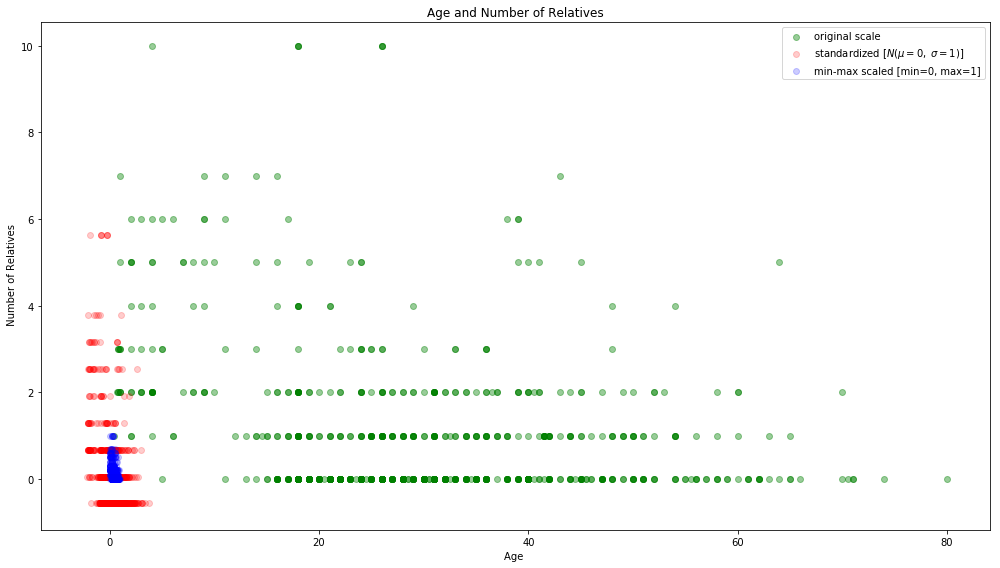

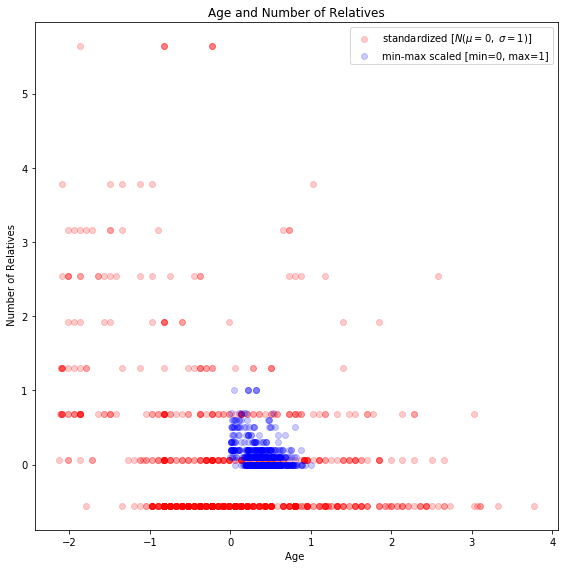

In [106]:
plot_all(train['Age'],train['Age_std'],train['Age_minmax'],
         train['NumRelatives'],train['NumRelatives_std'],train['NumRelatives_minmax'],
        'Age and Number of Relatives')

plt.show()

plot_scaled(train['Age'],train['Age_std'],train['Age_minmax'],
         train['NumRelatives'],train['NumRelatives_std'],train['NumRelatives_minmax'],
        'Age and Number of Relatives')

plt.show()

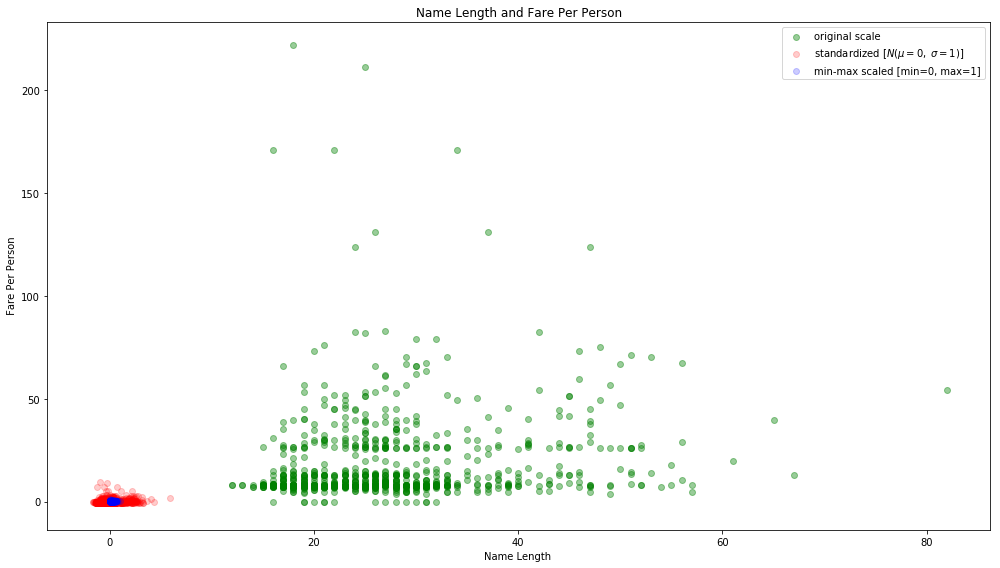

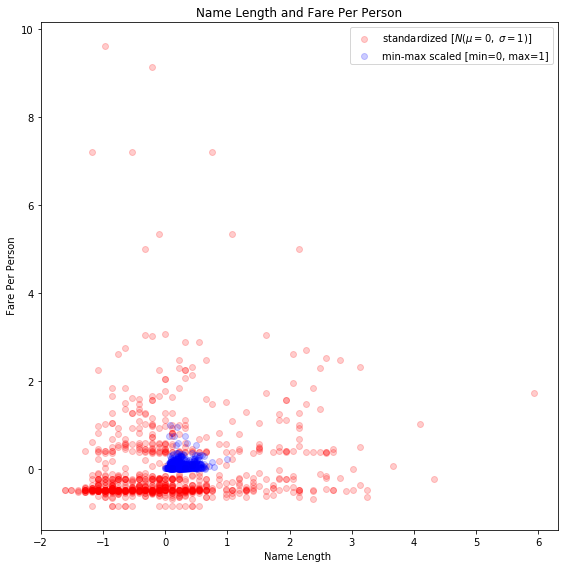

In [107]:
plot_all(train['NameLength'],train['NameLength_std'],train['NameLength_minmax'],
         train['FarePerPerson'],train['FarePerPerson_std'],train['FarePerPerson_minmax'],
        'Name Length and Fare Per Person')

plt.show()

plot_scaled(train['NameLength'],train['NameLength_std'],train['NameLength_minmax'],
         train['FarePerPerson'],train['FarePerPerson_std'],train['FarePerPerson_minmax'],
        'Name Length and Fare Per Person')

plt.show()